# 3.0 Feature Engineering

## Import libraries

In [1]:
# Sirve para actualizar el modulo despues de haber cambiado algo en el codigo de los modulos importados
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [3]:
# Modulos propios del proyecto que se encuentran en el directorio src
from src.utils.paths import data_dir
from src.utils.paths import references_dir


## Set up

In [4]:
# Configuracion de opciones

# Configuramos para que muestre siempre todas las columnas disponibles
pd.options.display.max_columns = None

In [5]:
# Definimos el constantes de colores de acuerdo al negocio para usar en los plots
COLOR_VINO_TINTO = "#7C3030"
COLOR_VINO_BLANCO = "#ffffbf"

## Read Data

In [6]:
# Obtenemos la ruta de los csv's que vamos a utilizar
WINE_CSV_PATH = data_dir("processed", "df_wine_after_eda.csv")

WINE_CSV_PATH

WindowsPath('c:/Users/cvigo/data-projects/proyecto-final-vinos/vinos-corderhouse/data/processed/df_wine_after_eda.csv')

In [7]:
# Leemos los csv's y los guardamos en un dataframe
df_wine = pd.read_csv(WINE_CSV_PATH)

In [8]:
# Corregimos los tipos de datos
df_wine["quality"] = df_wine["quality"].astype("category").cat.as_ordered()
df_wine["style"] = df_wine["style"].astype("category")
df_wine["body"] = df_wine["body"].apply(lambda x: f'{x:.0f}').astype("category")
df_wine["rating"] = df_wine["rating"].astype("category").cat.codes.astype("category").cat.as_ordered()

# Normalizacion

array([[<AxesSubplot:title={'center':'fixed_acidity'}>,
        <AxesSubplot:title={'center':'volatile_acidity'}>,
        <AxesSubplot:title={'center':'citric_acid'}>,
        <AxesSubplot:title={'center':'residual_sugar'}>],
       [<AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free_sulfur_dioxide'}>,
        <AxesSubplot:title={'center':'total_sulfur_dioxide'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'num_reviews'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'acidity'}>, <AxesSubplot:>]],
      dtype=object)

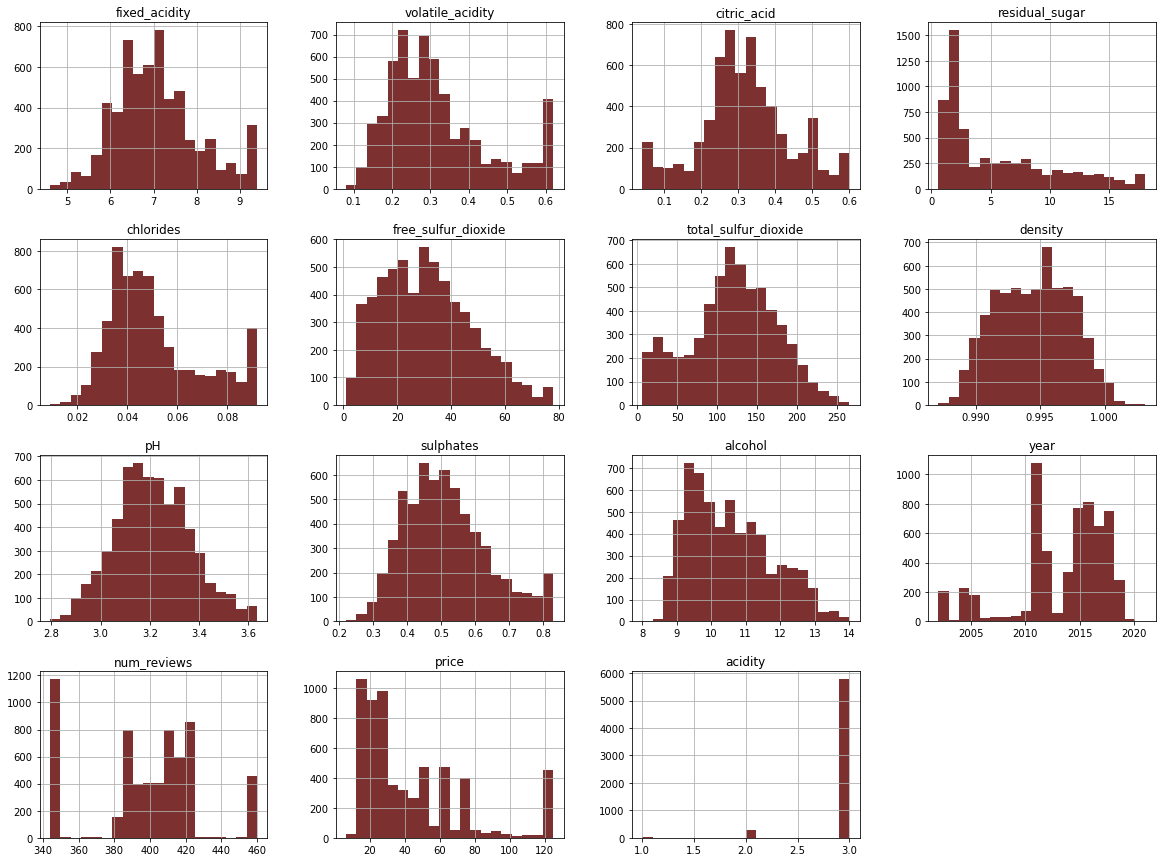

In [9]:
# Vemos la distribucion hist
df_wine.hist(bins=20, figsize=(20,15), color = COLOR_VINO_TINTO)

Tenemos que preparar los datos para el analisis de PCA, para esto tenemos que sacarle las unidades a los datos. 
Como la distribuicion en parte de los datos no tiene una forma normal, es mejor para este caso aplicar normalizacion en vez de estandarizacion.
$$
\text{Normalizacion} = \frac{x - \text{min}}{\text{max} - \text{min}}
$$

In [10]:
# Nuevo dataframe con solo las columnas de tipo numericas
df_wine_numeric = df_wine.select_dtypes(include=['float64', 'int64'])
df_wine_numeric.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,year,num_reviews,price,acidity
0,7.8,0.62,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2013,344,124.88,3.0
1,9.4,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2018,344,124.88,2.0
2,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,2009,460,124.88,3.0
3,7.3,0.62,0.04,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,2002,460,124.88,3.0
4,7.8,0.58,0.04,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,2002,460,124.88,3.0


In [11]:
# Filtramos por las columnas que no tiene rango de valores enter 0 y 1
colums_to_normalice = df_wine_numeric.loc[:, df_wine_numeric.max() > 1].columns.tolist()
colums_to_normalice


['fixed_acidity',
 'residual_sugar',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'alcohol',
 'year',
 'num_reviews',
 'price',
 'acidity']

In [12]:
# Normalizamos los datos con sklearn minmaxscaler
scaler = MinMaxScaler()
arr_wine_numeric_normalice = scaler.fit_transform(df_wine_numeric[colums_to_normalice].astype(float))
# Convertimos el array de nuevo en un dataframe
df_numeric_scaled = pd.DataFrame(arr_wine_numeric_normalice, columns=colums_to_normalice,index=df_wine_numeric[colums_to_normalice].index)
# Reemplazamos los valores originales por los normalizados
df_wine.loc[:, colums_to_normalice] = df_numeric_scaled
df_wine_numeric.loc[:, colums_to_normalice] = df_numeric_scaled
df_wine_numeric.shape , df_wine.shape

((6067, 15), (6067, 20))

In [13]:
# Guardamos el dataframe con los datos normalizados
df_wine.to_csv(data_dir("processed", "df_wine_num_normalice.csv"))

# PCA y reduccion de dimensionalidad

Para el analisis de PCA necesitamos trabajar solo con las variables numéricas por lo que creamos un dataframe con solo las variables numéricas.

In [14]:
# Creamos una lista de lo PCs que coincide con la cantidad de columnas
list_pcs = ["PC" + str(index+1) for index in range(len(df_wine_numeric.columns))]
list_pcs

['PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PC10',
 'PC11',
 'PC12',
 'PC13',
 'PC14',
 'PC15']

In [15]:
# PCA
# Creamos un objeto PCA
pca_model = PCA()
# Aplicamos el PCA
pca_model.fit_transform(df_wine_numeric)
# Creamos un dataframe con los datos de la PCA
df_wine_numeric_scaled_pca = pd.DataFrame(data = pca_model.components_ , columns=df_wine_numeric.columns, index= list_pcs)
df_wine_numeric_scaled_pca.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,year,num_reviews,price,acidity
PC1,0.176318,0.155761,-0.059870,-0.451244,0.019329,-0.373101,-0.410659,-0.055704,0.147202,0.104851,0.134172,-0.211517,-0.349370,0.455277,-0.037199
PC2,0.222667,0.068591,0.036733,0.472179,0.022576,0.126038,0.116812,0.457975,-0.072727,0.051373,-0.393948,-0.247707,-0.329701,0.384328,-0.027180
PC3,-0.172116,-0.030238,-0.025869,-0.034197,-0.006877,0.109890,0.105075,-0.090331,0.078285,-0.018872,0.038895,-0.667509,0.606236,0.338498,0.025118
PC4,0.510811,0.085965,0.067159,0.050131,0.018710,-0.400215,-0.269681,0.255123,-0.221558,0.047104,-0.155920,0.143312,0.564567,-0.099851,0.038190
PC5,-0.416964,0.205943,-0.283642,0.112334,0.022766,-0.181335,-0.153743,0.260643,0.639867,0.110198,-0.279281,0.199846,0.159124,-0.027178,-0.010765


A partir de los componentes del modelo PCA entrenado podemos ver los pesos que tiena cada variable en esa componenete

<AxesSubplot:>

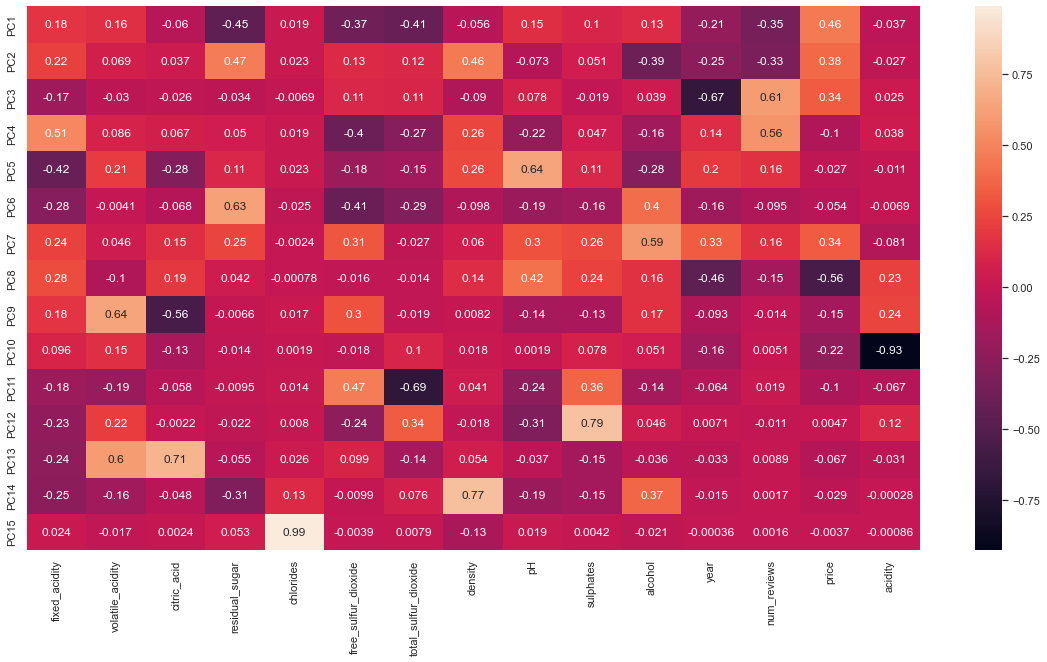

In [16]:
sns.set(rc={'figure.figsize':(20,10)})
# Graficamos los datos de la PCA como heatmap
sns.heatmap(df_wine_numeric_scaled_pca, annot=True)

Con este grafico podemos ver las variables que mas inciden para cada componente, por ejemplo:
- Para el PC1 la variable que mas incide en price
- Para el PC2 la variable que mas incide en residual_sugar
- Para el PC3 la variable que mas incide en num_reviews

Y asu sucesivamente.

In [17]:
# Observamos la varianza explicada de cada component para eso utilizamos .explained_variance_ratio_
explained_varaiance_ratio = pd.Series( pca_model.explained_variance_ratio_.round(4) * 100, index=list_pcs)

explained_varaiance_ratio

PC1     27.88
PC2     19.73
PC3     10.87
PC4      9.85
PC5      7.47
PC6      5.58
PC7      4.17
PC8      3.75
PC9      2.71
PC10     2.47
PC11     2.04
PC12     1.94
PC13     1.28
PC14     0.24
PC15     0.02
dtype: float64

Podemos observar que el componenete PC1 explica el 27.88 % de los datos y el PC2 explica el 19.73 % de los datos

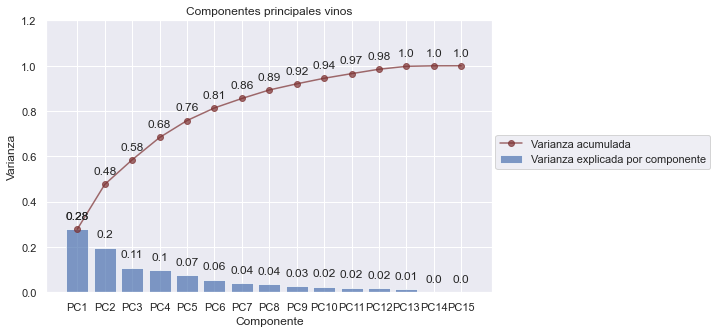

In [18]:
# Graficamos la varianza de cada PC y la varianza acumulada
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(list_pcs, pca_model.explained_variance_ratio_, alpha=0.7, label='Varianza explicada por componente')
ax.plot(list_pcs, pca_model.explained_variance_ratio_.cumsum(), 'o-', alpha=0.7, label='Varianza acumulada', color=COLOR_VINO_TINTO)
for x, y in zip(np.arange(len(df_wine_numeric.columns)), pca_model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(label,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center'
               )
for x, y in zip(np.arange(len(df_wine_numeric.columns)), pca_model.explained_variance_ratio_.cumsum()):
    label = round(y, 2)
    ax.annotate(label,
                (x,y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center'
               )
ax.set_title('Componentes principales vinos')
ax.set_xlabel('Componente')
ax.set_ylabel('Varianza')
ax.set_ylim(0, 1.2)
ax.legend(bbox_to_anchor = (1.5, 0.6))

Hasta el PC8 tenemos el 89% de los datos explicados.
Para esta instancia tenemos dos criterios para determinar con que componentes principales nos quedamos ya que el objetivo es redusir dimensionalidad.


In [19]:
df_explained_variance_ratio = pd.DataFrame({"varianza": explained_varaiance_ratio, "varianza_acumulada": pd.Series(explained_varaiance_ratio.cumsum(), index=list_pcs)})
df_explained_variance_ratio

,varianza,varianza_acumulada
PC1,27.88,27.88
PC2,19.73,47.61
PC3,10.87,58.48
PC4,9.85,68.33
PC5,7.47,75.80
PC6,5.58,81.38
PC7,4.17,85.55
PC8,3.75,89.30
PC9,2.71,92.01
PC10,2.47,94.48


Por un lado tenemos el criterio de varianza acumulada superior a un umbral, que por lo general se recomienda mayor al 80% de la varianza total. Para este caso tendriamos que tomar los compoenentes hasta el PC6.
Por otro lado tenemos el criterio del autovalor > 1 donde sumamos por cada componente el autovalor y si la suma es mayor a 1, entonces ese componente es importante.



In [20]:
# criterio del autovalor
ds_autovalue = pd.Series(df_wine_numeric_scaled_pca.sum(axis=1), index=list_pcs)
ds_autovalue

PC1    -0.755753
PC2     0.888011
PC3     0.255991
PC4     0.633846
PC5     0.357814
PC6    -0.819601
PC7     2.916103
PC8     0.387924
PC9     0.442160
PC10   -0.957747
PC11   -0.836688
PC12    0.699865
PC13    0.719241
PC14    0.191156
PC15    0.928748
dtype: float64

In [21]:
# Filtramos los que cumplen con el criterio de mayor a 1
ds_autovalue_filtered = ds_autovalue[ds_autovalue > 1]
ds_autovalue_filtered

PC7    2.916103
dtype: float64

En este caso solo tenemos un componente, por lo que reducir la dimensionalidad de 15 a 1 es riesgoso porque se pierde una gran cantidad de informacion. Para este caso utlizaremos el criterio de la variacion acumulada.


In [22]:
df_explained_variance_ratio

,varianza,varianza_acumulada
PC1,27.88,27.88
PC2,19.73,47.61
PC3,10.87,58.48
PC4,9.85,68.33
PC5,7.47,75.80
PC6,5.58,81.38
PC7,4.17,85.55
PC8,3.75,89.30
PC9,2.71,92.01
PC10,2.47,94.48


Tomaremos los componentes del 1 a 7 inclusive.

In [23]:
# filtramos df_explained_variance_ratio varianza_acumulada <=85.55
components_to_keep = df_explained_variance_ratio[df_explained_variance_ratio["varianza_acumulada"] <= 85.55].index
components_to_keep

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], dtype='object')

Teniendo identificadas las columnas, ahora nos queda calcular la transformacion de los datos originales con .transform()

In [24]:
# Utilizamos .transform calcular la funcion para cada datos y generar el resultado
df_wine_transform_pca = pd.DataFrame(pca_model.transform(df_wine_numeric), columns=list_pcs, index=df_wine_numeric.index)
print(f"{df_wine_transform_pca.shape=}")
df_wine_transform_pca.head()

df_wine_transform_pca.shape=(6067, 15)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,0.830609,0.440232,-0.117956,-0.050263,0.158908,-0.066726,0.043196,-0.280126,0.189439,-0.087937,-0.012663,0.092318,-0.084566,-0.003001,0.009103
1,0.730739,0.487015,-0.374169,0.165219,-0.218480,-0.237366,0.262672,-0.347755,-0.373995,0.245304,-0.018462,-0.133257,0.026814,0.025703,-0.003805
2,0.515117,0.145376,0.636960,0.468123,0.267895,-0.165759,0.052466,-0.364713,0.180200,-0.069832,-0.067099,-0.088294,-0.045215,-0.024246,-0.006833
3,0.682091,0.083386,0.911991,0.322550,0.288466,-0.011833,-0.017154,-0.186824,0.218551,-0.028818,0.036660,-0.125301,0.000729,-0.064881,-0.002420
4,0.693912,0.217874,0.863559,0.469675,0.305220,-0.033145,-0.032222,-0.136435,0.168343,-0.019373,0.059208,-0.060223,-0.060043,-0.031958,-0.004334


A partir de los componentes del modelo PCA entrenado podemos ver los pesos que tiena cada variable en esa componenete

In [25]:
df_explained_variance_ratio

,varianza,varianza_acumulada
PC1,27.88,27.88
PC2,19.73,47.61
PC3,10.87,58.48
PC4,9.85,68.33
PC5,7.47,75.80
PC6,5.58,81.38
PC7,4.17,85.55
PC8,3.75,89.30
PC9,2.71,92.01
PC10,2.47,94.48


In [26]:
# Nos quedamos solamente con las columnas que cumplen con el criterio que elegimos
df_wine_transform_pca = df_wine_transform_pca[components_to_keep]
print(f"{df_wine_transform_pca.shape=}")
df_wine_transform_pca.head()

df_wine_transform_pca.shape=(6067, 7)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.830609,0.440232,-0.117956,-0.050263,0.158908,-0.066726,0.043196
1,0.730739,0.487015,-0.374169,0.165219,-0.218480,-0.237366,0.262672
2,0.515117,0.145376,0.636960,0.468123,0.267895,-0.165759,0.052466
3,0.682091,0.083386,0.911991,0.322550,0.288466,-0.011833,-0.017154
4,0.693912,0.217874,0.863559,0.469675,0.305220,-0.033145,-0.032222


In [27]:
columns_not_numeric = [col for col in df_wine.columns if col not in df_wine_numeric.columns]
columns_not_numeric

['quality', 'style', 'rating', 'region', 'body']

In [28]:
df_wine_transform_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.830609,0.440232,-0.117956,-0.050263,0.158908,-0.066726,0.043196
1,0.730739,0.487015,-0.374169,0.165219,-0.218480,-0.237366,0.262672
2,0.515117,0.145376,0.636960,0.468123,0.267895,-0.165759,0.052466
3,0.682091,0.083386,0.911991,0.322550,0.288466,-0.011833,-0.017154
4,0.693912,0.217874,0.863559,0.469675,0.305220,-0.033145,-0.032222


# Encoding

Trataremos las columnas categoricas

In [33]:
df_wine[columns_not_numeric]

,quality,style,rating,region,body
0,low,red,7,Toro,5
1,high,red,7,Vino de Espana,4
2,low,red,6,Ribera del Duero,5
3,high,red,6,Ribera del Duero,5
4,high,red,6,Ribera del Duero,5
...,...,...,...,...,...
6062,high,white,0,Rioja,4
6063,low,white,0,Priorato,4
6064,high,white,0,Otras,4
6065,high,white,0,Ribera del Duero,5


##  quality

Quality es la variable target. Nos interesa determinar si es de calidad alto, entoces lo codificaremos como get_dummies() donde 1 va a ser calidad alto y 0 calidad baja.

In [34]:
# get dummies of quality
df_wine_encoding = pd.get_dummies(df_wine['quality'])
df_wine_encoding.head()

,high,low
0,0,1
1,1,0
2,0,1
3,1,0
4,1,0


In [35]:
# eliminamos la columana low
df_wine_encoding.drop(['low'], axis=1, inplace=True)
# cambiamos el nombre de la columna high 
df_wine_encoding.rename(columns={'high':'quality_high'}, inplace=True)
df_wine_encoding.head()

,quality_high
0,0
1,1
2,0
3,1
4,1


## Body

In [36]:
df_wine.body.value_counts()

4    3868
5    1612
3     553
2      34
Name: body, dtype: int64

Como body no tiene jerarquia, lo codificaremos con get_dummies() 

In [37]:
# get_dummies de la columna body
df_wine_encoding = pd.concat([df_wine_encoding, pd.get_dummies(df_wine['body'],prefix='body')], axis=1)    
df_wine_encoding.head()

,quality_high,body_2,body_3,body_4,body_5
0,0,0,0,0,1
1,1,0,0,1,0
2,0,0,0,0,1
3,1,0,0,0,1
4,1,0,0,0,1


## Style

In [38]:
# get_dummies de la columna style
df_wine_encoding = pd.concat([df_wine_encoding, pd.get_dummies(df_wine['style'],prefix='style')], axis=1)    
df_wine_encoding.head()

,quality_high,body_2,body_3,body_4,body_5,style_red,style_white
0,0,0,0,0,1,1,0
1,1,0,0,1,0,1,0
2,0,0,0,0,1,1,0
3,1,0,0,0,1,1,0
4,1,0,0,0,1,1,0


## Region

In [40]:
df_wine['region'].value_counts()

Rioja               2221
Ribera del Duero    1277
Otras               1221
Priorato             622
Toro                 264
Vino de Espana       238
Rias Baixas          224
Name: region, dtype: int64

In [41]:
# get_dummies de la columna style
df_wine_encoding = pd.concat([df_wine_encoding, pd.get_dummies(df_wine['region'],prefix='region')], axis=1)    
df_wine_encoding.head()

,quality_high,body_2,body_3,body_4,body_5,style_red,style_white,region_Otras,region_Priorato,region_Rias Baixas,region_Ribera del Duero,region_Rioja,region_Toro,region_Vino de Espana
0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
1,1,0,0,1,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,1,1,0,0,0,0,1,0,0,0
3,1,0,0,0,1,1,0,0,0,0,1,0,0,0
4,1,0,0,0,1,1,0,0,0,0,1,0,0,0


In [42]:
df_wine_encoding.shape

(6067, 14)

In [43]:
# Merge de las dos tablas
df_wine_complete = pd.concat([df_wine_encoding, df_wine_transform_pca], axis=1)
df_wine_complete.head()

,quality_high,body_2,body_3,body_4,body_5,style_red,style_white,region_Otras,region_Priorato,region_Rias Baixas,region_Ribera del Duero,region_Rioja,region_Toro,region_Vino de Espana,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0.830609,0.440232,-0.117956,-0.050263,0.158908,-0.066726,0.043196
1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0.730739,0.487015,-0.374169,0.165219,-0.218480,-0.237366,0.262672
2,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0.515117,0.145376,0.636960,0.468123,0.267895,-0.165759,0.052466
3,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0.682091,0.083386,0.911991,0.322550,0.288466,-0.011833,-0.017154
4,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0.693912,0.217874,0.863559,0.469675,0.305220,-0.033145,-0.032222


In [44]:
# Guardamos el dataframe en un archivo csv
df_wine_complete.to_csv(data_dir("processed",'df_wine_complete.csv'), index=False)